Most of the dependencies are handled in the other modules, but we import a few general ones here for use below and future expansion purposes.
Notice that we are also modifying the matplotlib settings to work with LaTeX math-mode syntax.

In [24]:
import matplotlib
matplotlib.use('pgf')
from matplotlib import pyplot as plt
import pymatching # Decoding

Add some functions that can allow us to generate circuits, perhaps complex ones, using basic function arguments. In the end, what we would want to do is to write a master function to compose sinter tasks such that it receives these circuit generator functions and a dictionary for their arguments.

In [2]:
from circuit_generators import get_builtin_circuit

Here are master functions to use sinter to benchmark built-in or other custom decoders with various circuits to make sampling tasks, collect their results, and make various plots.

In [29]:
from sampling_functions import create_task_sinter, generate_samples_sinter, get_variable_from_sample_sinter, plot_error_rate_sinter

Let's run the repetition code example from stim [getting_started](https://github.com/quantumlib/Stim/blob/main/doc/getting_started.ipynb) manual using the above master functions.

In [41]:
n_samples = 1000000
decoders = ['pymatching']
distances = sorted([3, 5, 7, 9])
rounds_over_distance = 3
noise_levels = sorted([0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5])

tasks = [
  create_task_sinter(
    fcn_circuit_generator = get_builtin_circuit,
    args_circuit_generator = {"builtin_name": "repetition_code:memory", "distance": d, "rounds": rounds_over_distance*d, "before_round_data_depolarization": noise},
    json_metadata = {'distance': d, 'noise': noise, 'rounds': rounds_over_distance*d}
  )
  for d in distances
  for noise in noise_levels
]

results = generate_samples_sinter(
  num_workers = 4,
  tasks = tasks,
  decoders = decoders,
  num_samples = n_samples
)

Let's make figures for error rates per shot...

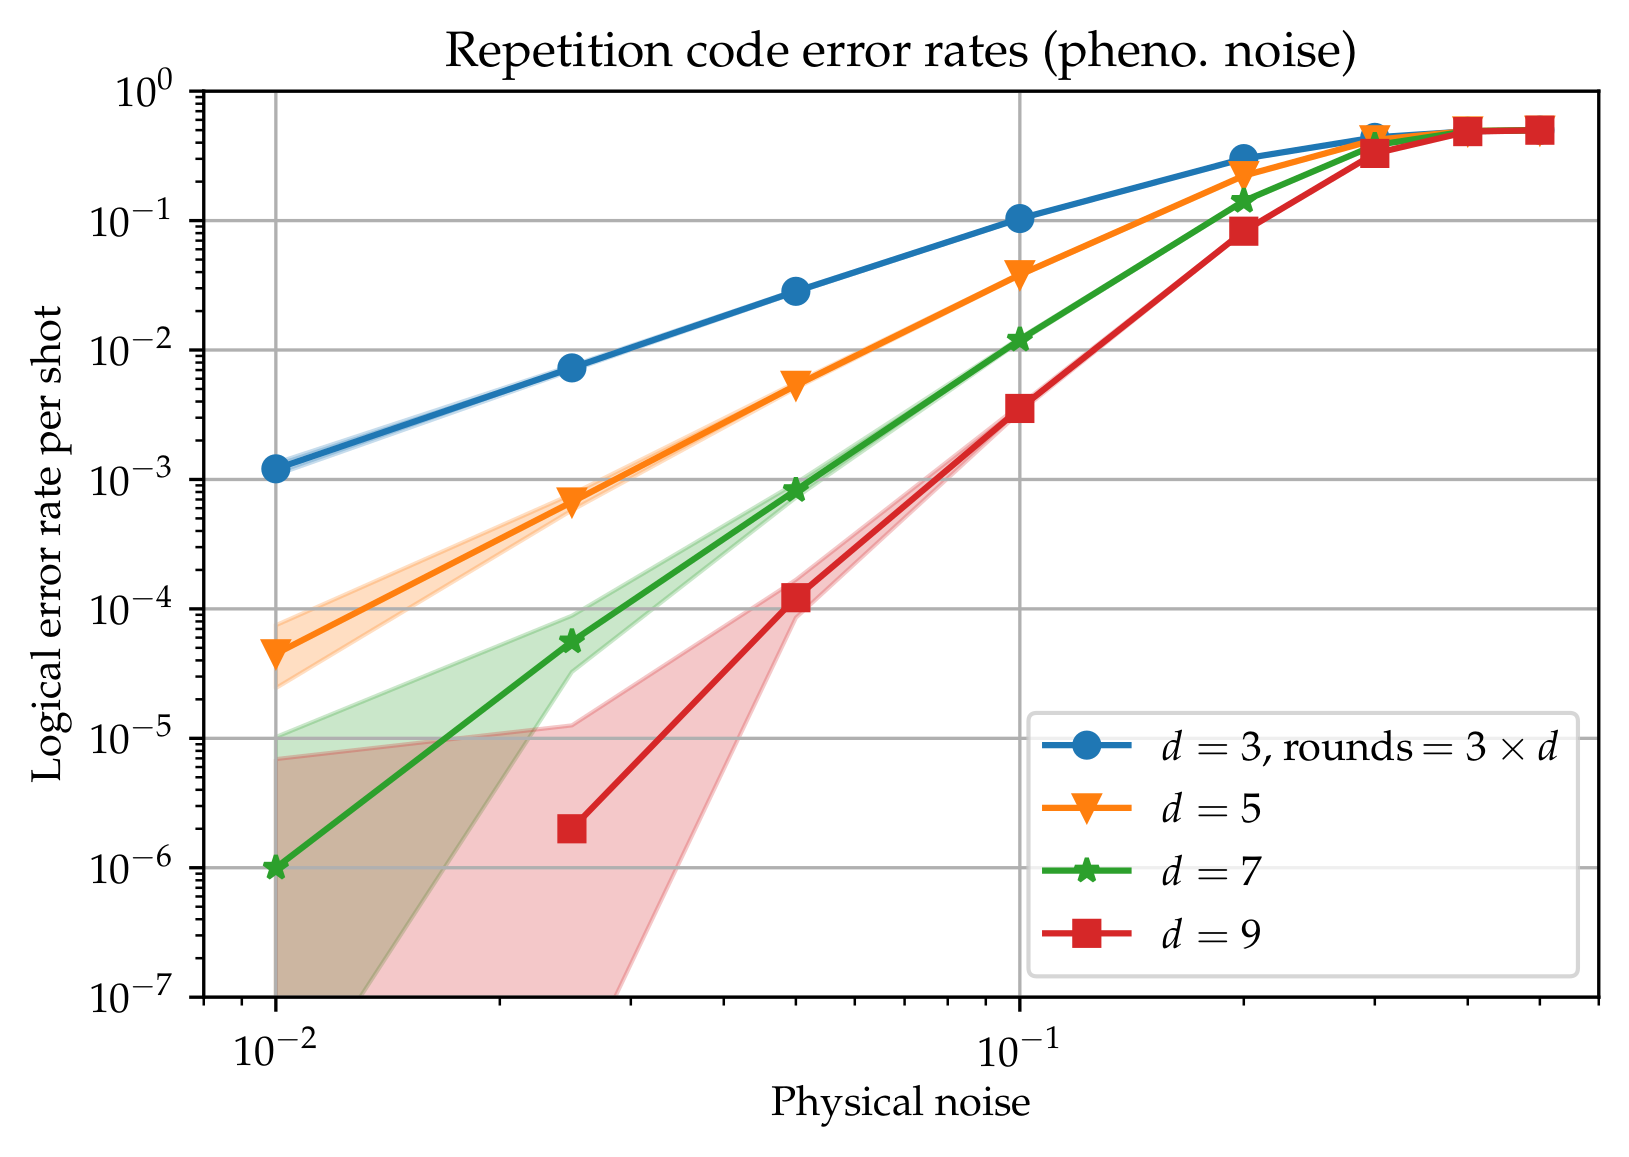

In [45]:
fig, ax = plt.subplots(1, 1)
plot_error_rate_sinter(
  ax, results, "noise", "Physical noise", "Logical error rate per shot",
  plot_label="Repetition code error rates (pheno. noise)",
  group_title="distance", group_labels={3: f"$d=3$, rounds$\,={rounds_over_distance} \\times d$", 5: "$d=5$", 7: "$d=7$", 9: "$d=9$"},
  x_range=(noise_levels[0]*0.8, noise_levels[-1]*1.2), y_range=(1e-7, 1.)  
)
fig.set_dpi(300)

...and per round.

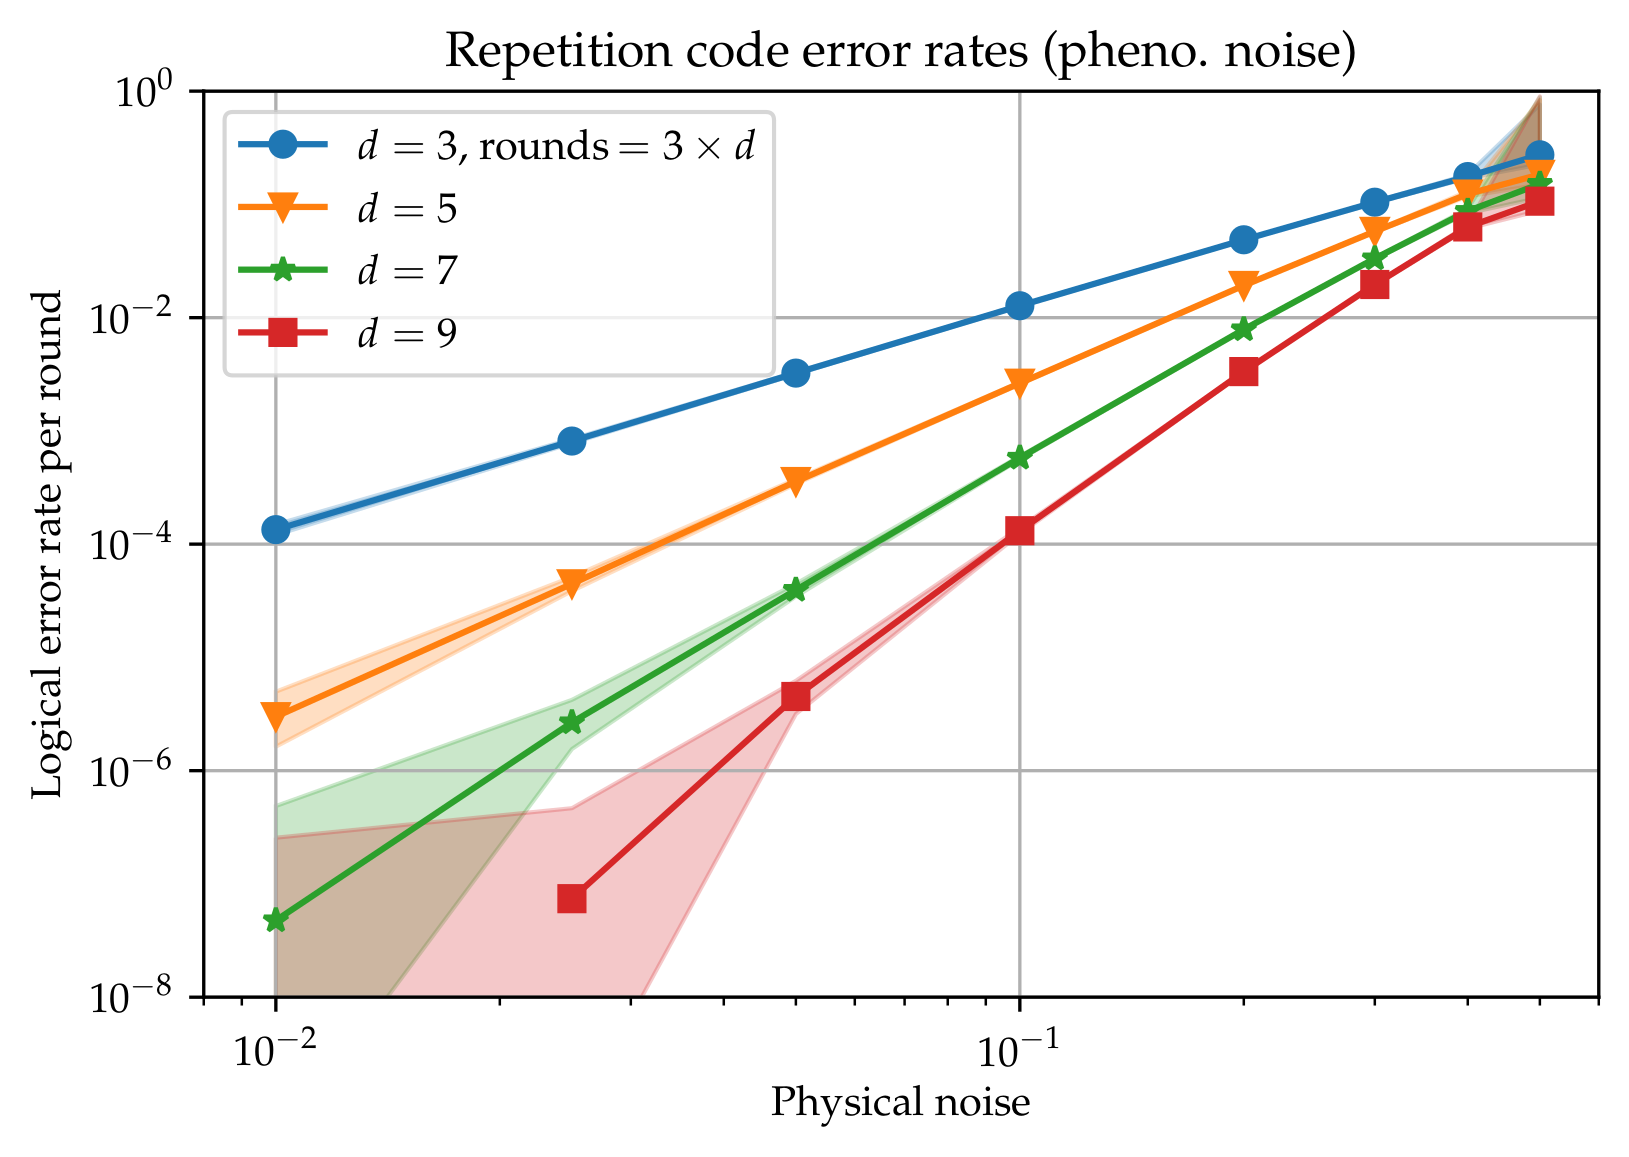

In [47]:
fig, ax = plt.subplots(1, 1)
plot_error_rate_sinter(
  ax, results, "noise", "Physical noise", "Logical error rate per round",
  plot_label="Repetition code error rates (pheno. noise)",
  group_title="distance", group_labels={3: f"$d=3$, rounds$\,={rounds_over_distance} \\times d$", 5: "$d=5$", 7: "$d=7$", 9: "$d=9$"},
  x_range=(noise_levels[0]*0.8, noise_levels[-1]*1.2), y_range=(1e-8, 1.),
  failure_units_per_shot_func = lambda st, tt="rounds": get_variable_from_sample_sinter(st, tt)
)
fig.set_dpi(300)

Let's try surface codes...

In [51]:
n_samples = 1000000
decoders = ['pymatching']
distances = sorted([3, 4, 5])
rounds_over_distance = 3
noise_levels = sorted([0.0001, 0.0005, 0.001, 0.0015, 0.003, 0.005, 0.05])
tasks = [
  create_task_sinter(
    fcn_circuit_generator = get_builtin_circuit,
    args_circuit_generator = {
      # 'Rotated' vs 'unrotated': https://arxiv.org/abs/1111.4022
      # 'memory_z' means we use a memory experiment, and initialize and measure the logical Z basis observable.
      "builtin_name": "surface_code:rotated_memory_z", "distance": d, "rounds": rounds_over_distance*d,
      "after_reset_flip_probability": noise,
      "after_clifford_depolarization": noise,
      "before_round_data_depolarization": noise,
      "before_measure_flip_probability": noise,
      },
    json_metadata = {'distance': d, 'noise': noise, 'rounds': rounds_over_distance*d}
  )
  for d in distances
  for noise in noise_levels
]

n_samples = 1000000
decoders = ['pymatching']
results = generate_samples_sinter(
  num_workers = 4,
  tasks = tasks,
  decoders = decoders,
  num_samples = n_samples,
)

Let's make the figures: Logical error rate per shot...

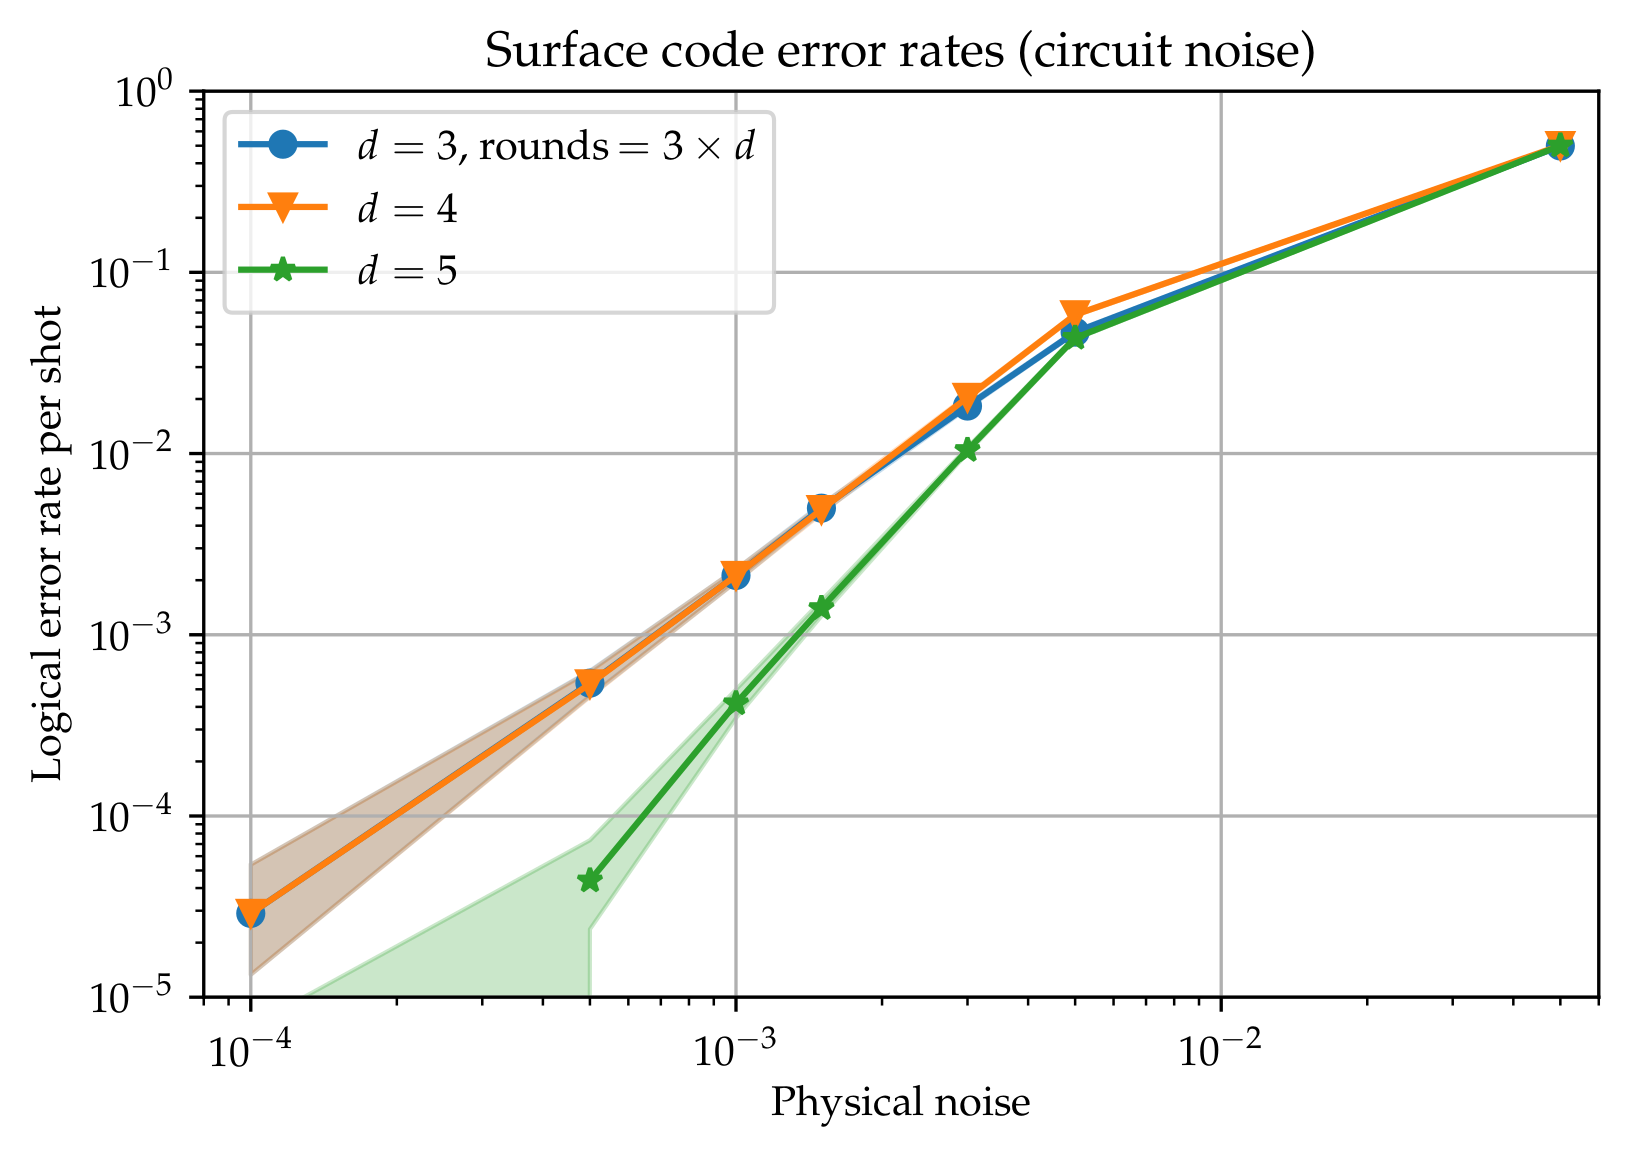

In [56]:
fig, ax = plt.subplots(1, 1)
plot_error_rate_sinter(
  ax, results, "noise", "Physical noise", "Logical error rate per shot",
  plot_label="Surface code error rates (circuit noise)",
  group_title="distance", group_labels={3: f"$d=3$, rounds$\,={rounds_over_distance} \\times d", 4: "$d=4$", 5: "$d=5$"},
  x_range=(noise_levels[0]*0.8, noise_levels[-1]*1.2), y_range=(1e-5, 1.)  
)
fig.set_dpi(300)

...and per round.

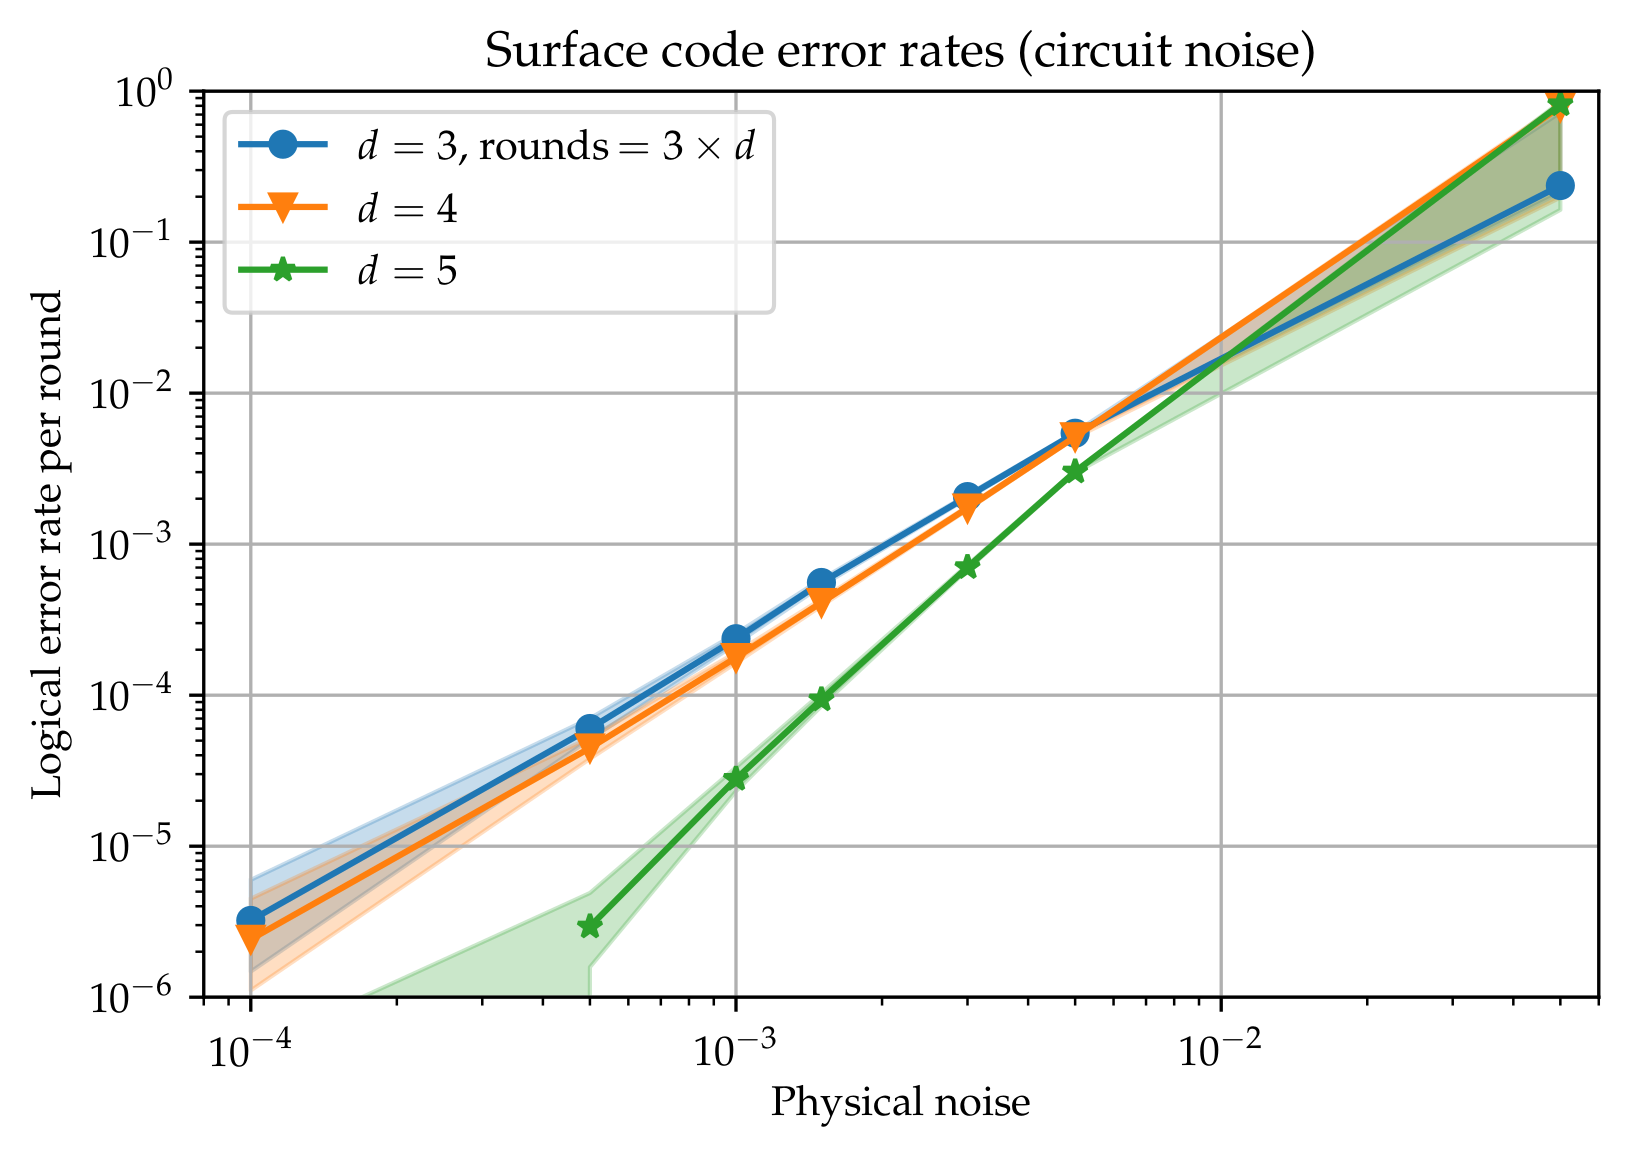

In [58]:
fig, ax = plt.subplots(1, 1)
plot_error_rate_sinter(
  ax, results, "noise", "Physical noise", "Logical error rate per round",
  plot_label="Surface code error rates (circuit noise)",
  group_title="distance", group_labels={3: f"$d=3$, rounds$\,={rounds_over_distance} \\times d", 4: "$d=4$", 5: "$d=5$"},
  x_range=(noise_levels[0]*0.8, noise_levels[-1]*1.2), y_range=(1e-6, 1.),
  failure_units_per_shot_func = lambda st, tt="rounds": get_variable_from_sample_sinter(st, tt)
)
fig.set_dpi(300)